# 230730_local_anal_weights_v7.ipynb
- all rank 애매한 부분 (ranking의 aggregation? 이 맞는지 확인하자)
- dataset_info_230806.tsv를 이용
- localisation 변경

# Import libraries

In [32]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math
import seaborn as sns


# Config

In [33]:
sns.set_style("darkgrid")

In [34]:
# dataset_nm = "Health_and_fitness"
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"
data_dir = "../m2d2/dataset"

device_id = 'cpu'
n_layers = 12

list_sources = ["WIKI", "S2ORC"]
list_categories = ["L1", "L2"]

# Data

## dataset_info

In [35]:
df_dataset = pd.read_csv("./data/dataset_info_230806.tsv", sep="\t")
list_models = df_dataset.loc[
    (df_dataset.valid)
    & (df_dataset.localisation)
    & (df_dataset.source.isin(list_sources))
    & (df_dataset.category.isin(list_categories)),
    "dataset"
].tolist()

df_dataset = df_dataset[["dataset", "source", "category"]]
df_dataset.head()

,dataset,source,category
0,Religion_and_belief_systems,WIKI,L1
1,Religion_and_belief_systems__Allah,WIKI,L2
2,nlin_l1,S2ORC,L1
3,nlin.PS,S2ORC,L2
4,Health_and_fitness,WIKI,L1


## model_info

In [36]:
def get_model_path(model_id):
    model_path_format = "/rds/general/user/jj1122/home/projects/m2d2/dataset/{model_id}/models"
    ckpt_path_format = "/checkpoint-{ckpt}"

    if model_id == "gpt2":
        model_path = "gpt2"
#         ckpt = "zs"
    else:
        model_path = model_path_format.format(model_id=model_id)
        l_dir = listdir(model_path)

        if all([len(x.split(".")) == 1 for x in l_dir]):
            ckpt = max([int(x.split("-")[1]) for x in l_dir])
            model_path += ckpt_path_format.format(ckpt=ckpt)
#         else:
#             ckpt = "final"
    return model_path

In [37]:
config_models = {model_id: {} for model_id in list_models}
for model_id in list_models:
    config_models[model_id]["model_path"] = get_model_path(model_id)
    json_path = config_models[model_id]["model_path"] + "/trainer_state.json"
    with open(json_path, "r") as json_file:
        trainer_state = json.load(json_file)
        config_models[model_id]["val_ppl"] = math.exp(trainer_state["best_metric"])
        config_models[model_id]["train_steps"] = int(trainer_state["best_model_checkpoint"].split("/")[-1].split("-")[-1])
        config_models[model_id]["train_eps"] = float(trainer_state["epoch"])

## submodule_info

In [38]:
def parse_code_submodule(row):
    list_code = row.code.split(".")
    row["trace_id"] = ".".join(row["code"].split(".")[:-1])
#     row["component_id"] = ".".join(row["code"].split(".")[1:-1])
    is_in_layer = row["code"].startswith("transformer.h")
    is_investigated = not row["code"].startswith("transformer.w")

    if is_in_layer:        
        row["layer"] = int(list_code[2])
        row["module"] = list_code[3]
    else:
        row["module"] = list_code[1]
        if row["module"] == "ln_f": 
            row["layer"] = int(99)
        elif row["module"] in ["wte", "wpe"]:
            row['layer'] = int(-1)
    
    if row["module"] in ["attn", "mlp"]:
        row["submodule"] = list_code[-2]
    else:
        row["submodule"] = row["module"]

    row["w_or_b"] = list_code[-1]
    row["is_in_layer"] = is_in_layer
    row["is_investigated"] = is_investigated

    return row

dict_n_parmas = {tup[0]: tup[1].numel() for tup in GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to("cpu").named_parameters()}
df_submodule = pd.DataFrame.from_dict(dict_n_parmas, orient="index").reset_index()
df_submodule.columns = ["code", 'params']
df_submodule = df_submodule.apply(lambda row: parse_code_submodule(row), axis=1)
df_temp = df_submodule.groupby("trace_id")["params"].sum().to_frame().reset_index()
df_temp.columns = ["trace_id", "total"]

df_submodule["display_id"] = df_submodule["layer"].astype(str) + "." + df_submodule["module"]

df_submodule.loc[df_submodule.module != df_submodule.submodule, "display_id"] \
    = df_submodule.loc[df_submodule.module != df_submodule.submodule, "display_id"] \
        + "." + df_submodule.loc[df_submodule.module != df_submodule.submodule, "submodule"]

df_submodule = df_submodule.merge(df_temp, on=["trace_id"])
df_submodule.head()

,code,is_in_layer,is_investigated,layer,module,params,submodule,trace_id,w_or_b,display_id,total
0,transformer.wte.weight,False,False,-1,wte,38597376,wte,transformer.wte,weight,-1.wte,38597376
1,transformer.wpe.weight,False,False,-1,wpe,786432,wpe,transformer.wpe,weight,-1.wpe,786432
2,transformer.h.0.ln_1.weight,True,True,0,ln_1,768,ln_1,transformer.h.0.ln_1,weight,0.ln_1,1536
3,transformer.h.0.ln_1.bias,True,True,0,ln_1,768,ln_1,transformer.h.0.ln_1,bias,0.ln_1,1536
4,transformer.h.0.attn.c_attn.weight,True,True,0,attn,1769472,c_attn,transformer.h.0.attn.c_attn,weight,0.attn.c_attn,1771776


# Difference in weights before and after fine-tuning
- Goal: 
    - The goal is to localise neural components, where domain knowledge is stored in LM using the difference between the weights.
    - The result from localisation, some specific components, will be utilised in the next steps, such as compression or editing, to validate the hypothesis that the neural components have domain knowledge.  


- Criteria to select: 
    - The neural components which have bigger difference are considered as the components that hold domian knowledge.
    - Depending on the difference between weights (ranking) and the number of parameters, The neural components would be seperated into 5 groups: top 0-25%, top 25-50%, top 50-75%, top 85-100%, and not investigated components.
    - That's why the difference between the weights and the its ranking is imperative. However, the magnitude of differences can be caused by not only domain knowledge itself, but also other aspects, such as training time.
    - not investigated components (layer normalisation, embedding layers)    
    
    
- Next steps (editing, compression):
    - editing (e.g. partial fine-tuning) ON: the last 50% layers vs top 0-50% components (baseline)
    - compression (e.g. partial pruning) ON: the first 50% layers vs top 50-100% components (baseline)
    - If it is successful, we will be able to prove specific neural components as the components have domain knowledge.
    - Furthermore, partially fine-tuning on the suggested components would be more beneficial and efficient than the last N layers which people believe.


## Raw Data
The differences in submodule's weights between fine-funed models and a pre-trained model.

In [39]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir=cache_dir)

In [40]:
def get_diff_from_tensors_sub(a, b):
    return torch.abs(a - b).mean().item()

dict_diff_weights = {}
for k, v_dict in config_models.items():
    print(k)
    tuned_model = GPT2LMHeadModel.from_pretrained(v_dict["model_path"]).to(device_id)
    for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
        assert tuned_tup[0] == base_tup[0]
        if tuned_tup[0].endswith("weight"):
            dict_diff_weights[k +"___"+tuned_tup[0]] = get_diff_from_tensors_sub(tuned_tup[1], base_tup[1]) 
    del tuned_model

Religion_and_belief_systems
Religion_and_belief_systems__Allah
nlin_l1
nlin.PS
Health_and_fitness
Health_and_fitness__Exercise
Natural_and_physical_sciences
Natural_and_physical_sciences__Physical_sciences
stat_l1
stat.CO
History_and_events
History_and_events__By_continent
q-bio_l1
q-bio.QM
cs_l1
cs.AI
Culture_and_the_arts
Culture_and_the_arts__Culture_and_Humanities
General_referece
General_referece__Further_research_tools_and_topics
Human_activites
Human_activites__Human_activities
Mathematics_and_logic
Mathematics_and_logic__Mathematics
astro-ph_l1
astro-ph.CO
cond-mat_l1
cond-mat.mtrl-sci
math_l1
math.NA
Philosophy_and_thinking
Philosophy_and_thinking__Philosophy
Society_and_social_sciences
Society_and_social_sciences__Society
Technology_and_applied_sciences
Technology_and_applied_sciences__Agriculture


**the models fine-tuned with above datasets were used.**  
(all L1 datasets and the L2 datasets in eight L1 datasets)

In [41]:
df_diff_weights = pd.DataFrame.from_dict(dict_diff_weights, orient='index').reset_index()
df_diff_weights.columns = ["code", "diff"]

df_diff_weights["dataset"] = df_diff_weights["code"].str.split("___").apply(lambda l: l[0])
df_diff_weights["code"] = df_diff_weights["code"].str.split("___").apply(lambda l: l[1])

df_diff_weights = df_diff_weights.merge(df_submodule, on=["code"])
df_diff_weights.loc[df_diff_weights["submodule"].str.startswith("ln"), "is_investigated"] = False   # TODO

df_diff_weights = df_diff_weights.merge(df_dataset, on=["dataset"])

for dataset, d in config_models.items():
    for k, v in d.items():
        if k != "model_path":
            df_diff_weights.loc[df_diff_weights.dataset == dataset, k] = v
df_diff_weights["log_train_steps"] = np.log(df_diff_weights['train_steps'])
df_diff_weights['scaled_diff'] = df_diff_weights['diff'] / df_diff_weights["train_steps"] * 10**4

df_diff_weights.loc[df_diff_weights.is_investigated, "in_rank"] \
    = df_diff_weights.loc[df_diff_weights.is_investigated].groupby(["dataset"])["diff"].rank(ascending=False)
df_diff_weights["in_rank"] = df_diff_weights["in_rank"].fillna(-1).astype(int)

df_diff_weights.head()

,code,diff,dataset,is_in_layer,is_investigated,layer,module,params,submodule,trace_id,...,display_id,total,source,category,val_ppl,train_steps,train_eps,log_train_steps,scaled_diff,in_rank
0,transformer.wte.weight,0.014526,Religion_and_belief_systems,False,False,-1,wte,38597376,wte,transformer.wte,...,-1.wte,38597376,WIKI,L1,20.796879,25000.0,19.715769,10.126631,0.005810,-1
1,transformer.wpe.weight,0.008403,Religion_and_belief_systems,False,False,-1,wpe,786432,wpe,transformer.wpe,...,-1.wpe,786432,WIKI,L1,20.796879,25000.0,19.715769,10.126631,0.003361,-1
2,transformer.h.0.ln_1.weight,0.024056,Religion_and_belief_systems,True,False,0,ln_1,768,ln_1,transformer.h.0.ln_1,...,0.ln_1,1536,WIKI,L1,20.796879,25000.0,19.715769,10.126631,0.009623,-1
3,transformer.h.0.attn.c_attn.weight,0.015205,Religion_and_belief_systems,True,True,0,attn,1769472,c_attn,transformer.h.0.attn.c_attn,...,0.attn.c_attn,1771776,WIKI,L1,20.796879,25000.0,19.715769,10.126631,0.006082,9
4,transformer.h.0.attn.c_proj.weight,0.010350,Religion_and_belief_systems,True,True,0,attn,589824,c_proj,transformer.h.0.attn.c_proj,...,0.attn.c_proj,590592,WIKI,L1,20.796879,25000.0,19.715769,10.126631,0.004140,42


In [42]:
df_diff_weights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             2700 non-null   object 
 1   diff             2700 non-null   float64
 2   dataset          2700 non-null   object 
 3   is_in_layer      2700 non-null   bool   
 4   is_investigated  2700 non-null   bool   
 5   layer            2700 non-null   int64  
 6   module           2700 non-null   object 
 7   params           2700 non-null   int64  
 8   submodule        2700 non-null   object 
 9   trace_id         2700 non-null   object 
 10  w_or_b           2700 non-null   object 
 11  display_id       2700 non-null   object 
 12  total            2700 non-null   int64  
 13  source           2700 non-null   object 
 14  category         2700 non-null   object 
 15  val_ppl          2700 non-null   float64
 16  train_steps      2700 non-null   float64
 17  train_eps     

In [43]:
len(df_diff_weights)

2700

In [44]:
df_diff_weights[["code", "dataset"]].nunique()

code       75
dataset    36
dtype: int64

The number of the **difference** of weights  
    = the number of **submodules** in a model $\times$ the number of **model**  
    = 75 * 58 = 4350  




## [Difference] Diff vs. Scaled_Diff

#### Original difference in weights
```original_diff = np.mean(np.abs(model_a.submodule.weights - model_b.submodule.weights))```

#### Scaling the difference of weights
```scaled_diff = original_diff  / train_steps  * 10**4```

### Reason 1: Correlation between `diff` and `train_steps` in a neural component

In [45]:
df_diff_weights.loc[df_diff_weights.is_investigated]\
    .groupby(["layer", "display_id"])[["train_steps", "diff", "val_ppl", "log_train_steps", "scaled_diff"]].corr().unstack(-1)\
    .loc[:, [
        ('train_steps', 'diff'),#('diff', 'log_train_steps'),#('diff', 'scaled_diff'), 
#         ('train_steps', 'scaled_diff'),#('scaled_diff', 'log_train_steps')#,('scaled_diff', 'diff')
    ]].stack()\
#     .mean().to_frame().T


train_steps
layer display_id                      
0     0.attn.c_attn  diff     0.990056
      0.attn.c_proj  diff     0.988345
      0.mlp.c_fc     diff     0.990476
      0.mlp.c_proj   diff     0.988652
1     1.attn.c_attn  diff     0.990195
      1.attn.c_proj  diff     0.989005
      1.mlp.c_fc     diff     0.990235
      1.mlp.c_proj   diff     0.988696
2     2.attn.c_attn  diff     0.990132
      2.attn.c_proj  diff     0.983814
      2.mlp.c_fc     diff     0.989442
      2.mlp.c_proj   diff     0.988019
3     3.attn.c_attn  diff     0.989721
      3.attn.c_proj  diff     0.981457
      3.mlp.c_fc     diff     0.988328
      3.mlp.c_proj   diff     0.986217
4     4.attn.c_attn  diff     0.989456
      4.attn.c_proj  diff     0.983554
      4.mlp.c_fc     diff     0.987979
      4.mlp.c_proj   diff     0.985748
5     5.attn.c_attn  diff     0.988042
      5.attn.c_proj  diff     0.981954
      5.mlp.c_fc     diff     0.986868
      5.mlp.c_proj   diff     0.985987
6     6.attn.c_attn  diff     0.987775
      6.attn.c_proj  diff     0.984979
      6.mlp.c_fc     diff     0.986164
      6.mlp.c_proj   diff     0.986642
7     7.attn.c_attn  diff     0.986680
      7.attn.c_proj  diff     0.982371
      7.mlp.c_fc     diff     0.985053
      7.mlp.c_proj   diff     0.987344
8     8.attn.c_attn  diff     0.986936
      8.attn.c_proj  diff     0.984344
      8.mlp.c_fc     diff     0.984689
      8.mlp.c_proj   diff     0.988484
9     9.attn.c_attn  diff     0.987170
      9.attn.c_proj  diff     0.985980
      9.mlp.c_fc     diff     0.984064
      9.mlp.c_proj   diff     0.989516
10    10.attn.c_attn diff     0.986288
      10.attn.c_proj diff     0.985843
      10.mlp.c_fc    diff     0.983723
      10.mlp.c_proj  diff     0.990242
11    11.attn.c_attn diff     0.986934
      11.attn.c_proj diff     0.988255
      11.mlp.c_fc    diff     0.983291
      11.mlp.c_proj  diff     0.990184

In [46]:
df_diff_weights.loc[df_diff_weights.is_investigated]\
    .groupby(["layer", "display_id"])[["train_steps", "diff", "val_ppl", "log_train_steps", "scaled_diff"]].corr().unstack(-1)\
    .loc[:, [
        ('train_steps', 'diff')
    ]].mean()


train_steps  diff    0.986986
dtype: float64

- If a model is **more trained**, the  **bigger difference** between the weights would be caused.
- We can isolate the effect from training time by dividing by `train_steps`, so that make sure the difference is caused by only domain knowledge.

In [47]:
# df_diff_weights.loc[df_diff_weights.is_investigated]\
#     .groupby(["layer", "display_id"])[["log_train_steps", "train_steps", "diff", "scaled_diff"]].corr().unstack(-1)\
#     .loc[:, [
#         ('train_steps', 'diff'), ('train_steps', 'scaled_diff'), 
#         ('log_train_steps', 'diff'), ('log_train_steps', 'scaled_diff')
#     ]]\
#     .mean().to_frame().T.


In [48]:
# df_diff_weights.loc[df_diff_weights.is_investigated]\
#     .groupby(["source", "category", "trace_id"])[["train_steps", "diff", "scaled_diff"]].corr().unstack(-1).reset_index()\
#     .groupby(["source", "category"])[[("train_steps", "scaled_diff"), ("train_steps", "diff")]].mean()#.unstack(-1).mean()#\
# #     .applymap(lambda x: np.nan if x == 1 else x).mean()

In [49]:
# df_diff_weights.loc[df_diff_weights.is_investigated]\
#     .groupby(["source", "category", "trace_id"])[["train_steps", "diff"]].corr().unstack(-1).reset_index()\
#     .groupby(["source", "category", "trace_id"])[[("train_steps", "diff")]].mean()\
#     .sort_values(("train_steps", "diff")).head(20)#.unstack(-1).mean()#\
# #     .applymap(lambda x: np.nan if x == 1 else x).mean()

In [50]:
# df_diff_weights.loc[df_diff_weights.is_investigated]\
#     .groupby(["source", "category", "log_train_steps", "train_steps", "train_eps", "dataset"])[["diff"]].mean()\
#     .reset_index().drop("dataset", axis=1).corr()

### Reason 2: Distributions of two differences

In [51]:
# sns.displot(
#     df_diff_weights.melt(id_vars=["code", "dataset", "trace_id"], value_vars=["diff", "scaled_diff"]),
#     x="value", hue="variable"
# )


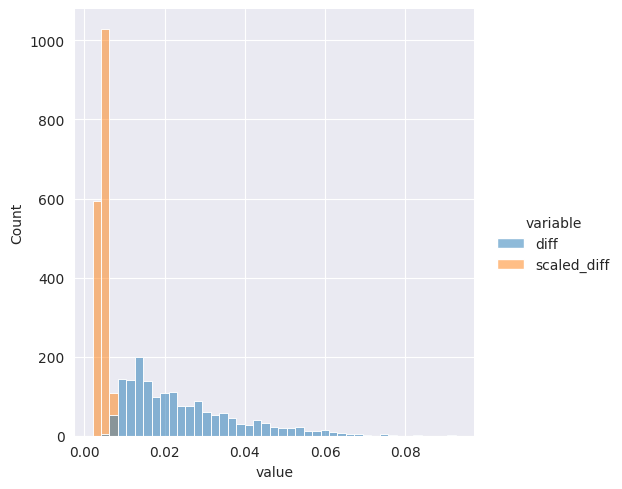

In [72]:
plt.rcParams["figure.figsize"] = (2, 10)
sns.displot(
    df_diff_weights.loc[df_diff_weights.is_investigated]\
        .melt(id_vars=["code", "dataset", "trace_id"], value_vars=["diff", "scaled_diff"]),
    x="value", hue="variable"
)


- Also, scaling can relieve the **skewness** and **kurtosis** on the distribution of the difference.  
- As a result, the average of the scaled differences can represent the differences more than original differences.

### skewness and kurtosis of distributions from the difference on each submodule

- ("diff", "kurt"): kurt before scaling 
- ("diff_kurt", ""): diff in kurt between them
- ("scaled_diff", "kurt"): kurt before scaling 
- ("diff", "skew"): skew before scaling 
- ("diff_skew", ""): diff in skew between them
- ("scaled_diff", "skew"): skew before scaling 


In [53]:
df_temp = df_diff_weights.loc[df_diff_weights.is_investigated]\
    .groupby(["layer", "display_id"])\
    .agg({
        "diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew], 
        "scaled_diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew]
    })

df_temp["diff_kurt"] = df_temp[("scaled_diff", "kurt")] - df_temp[("diff", "kurt")]
df_temp["diff_skew"] = df_temp[("scaled_diff", "skew")] - df_temp[("diff", "skew")]

df_temp[[
    ("diff", "kurt"), ("diff_kurt", ""), ("scaled_diff", "kurt"),
    ("diff", "skew"), ("diff_skew", ""), ("scaled_diff", "skew")
]]#.mean().to_frame().T

diff diff_kurt scaled_diff      diff diff_skew  \
                          kurt                  kurt      skew             
layer display_id                                                           
0     0.attn.c_attn   0.170783  1.101808    1.272590  0.951988 -2.059078   
      0.attn.c_proj   0.141123 -0.753319   -0.612196  0.940400 -1.034789   
      0.mlp.c_fc      0.209683  0.398768    0.608451  0.976588 -1.582609   
      0.mlp.c_proj    0.196347 -0.677128   -0.480781  0.977642 -0.800001   
1     1.attn.c_attn   0.171767  1.921142    2.092909  0.953724 -2.366639   
      1.attn.c_proj   0.151951 -0.367516   -0.215565  0.943263 -1.138599   
      1.mlp.c_fc      0.194256  0.330921    0.525178  0.971015 -1.525279   
      1.mlp.c_proj    0.186841 -0.629868   -0.443028  0.970549 -0.813976   
2     2.attn.c_attn   0.172868  1.436151    1.609019  0.954257 -2.156948   
      2.attn.c_proj  -0.026250 -0.605630   -0.631880  0.877265 -0.711202   
      2.mlp.c_fc      0.168115 -0.145954    0.022161  0.968323 -1.136750   
      2.mlp.c_proj    0.148619 -0.537756   -0.389137  0.956901 -0.792722   
3     3.attn.c_attn   0.161105  0.528256    0.689361  0.956059 -1.630839   
      3.attn.c_proj  -0.031416 -0.634020   -0.665436  0.882914 -0.559107   
      3.mlp.c_fc      0.137605 -0.337730   -0.200125  0.958877 -0.917286   
      3.mlp.c_proj    0.100435 -0.557708   -0.457272  0.939594 -0.669421   
4     4.attn.c_attn   0.151183  0.328893    0.480076  0.953118 -1.489523   
      4.attn.c_proj   0.032259 -0.589041   -0.556782  0.910229 -0.570688   
      4.mlp.c_fc      0.131274 -0.374110   -0.242836  0.955269 -0.851493   
      4.mlp.c_proj    0.102489 -0.575507   -0.473019  0.937714 -0.617770   
5     5.attn.c_attn   0.121010 -0.281867   -0.160858  0.944832 -0.968387   
      5.attn.c_proj   0.001023 -0.554715   -0.553692  0.899187 -0.521635   
      5.mlp.c_fc      0.108036 -0.447400   -0.339363  0.950381 -0.707696   
      5.mlp.c_proj    0.104890 -0.523283   -0.418393  0.939429 -0.625001   
6     6.attn.c_attn   0.113622 -0.259011   -0.145390  0.943507 -0.901763   
      6.attn.c_proj   0.065470 -0.459061   -0.393591  0.926892 -0.615269   
      6.mlp.c_fc      0.099463 -0.455111   -0.355648  0.948221 -0.618168   
      6.mlp.c_proj    0.121088 -0.452691   -0.331602  0.949089 -0.648757   
7     7.attn.c_attn   0.084128 -0.295448   -0.211320  0.936457 -0.777818   
      7.attn.c_proj   0.012781 -0.421247   -0.408466  0.907928 -0.467140   
      7.mlp.c_fc      0.075497 -0.448674   -0.373177  0.942841 -0.532041   
      7.mlp.c_proj    0.140698 -0.377489   -0.236791  0.955562 -0.673221   
8     8.attn.c_attn   0.093465 -0.264100   -0.170634  0.942634 -0.748292   
      8.attn.c_proj   0.056806 -0.358654   -0.301847  0.930643 -0.513678   
      8.mlp.c_fc      0.068810 -0.443091   -0.374282  0.938507 -0.505218   
      8.mlp.c_proj    0.168799 -0.240368   -0.071569  0.963004 -0.802351   
9     9.attn.c_attn   0.108595 -0.304277   -0.195681  0.945997 -0.733334   
      9.attn.c_proj   0.121886 -0.432320   -0.310434  0.954404 -0.571016   
      9.mlp.c_fc      0.058791 -0.425514   -0.366723  0.933972 -0.460161   
      9.mlp.c_proj    0.200957 -0.064445    0.136512  0.971490 -0.984347   
10    10.attn.c_attn  0.086957 -0.349570   -0.262613  0.934702 -0.656096   
      10.attn.c_proj  0.133841 -0.460603   -0.326762  0.951391 -0.532393   
      10.mlp.c_fc     0.061045 -0.411931   -0.350886  0.935650 -0.427878   
      10.mlp.c_proj   0.231076  0.107385    0.338461  0.980150 -1.156035   
11    11.attn.c_attn  0.108478 -0.400688   -0.292209  0.945694 -0.690172   
      11.attn.c_proj  0.192769 -0.397233   -0.204465  0.975011 -0.705609   
      11.mlp.c_fc     0.037278 -0.375295   -0.338017  0.926283 -0.426553   
      11.mlp.c_proj   0.216774  0.300577    0.517351  0.976520 -1.258330   

                     scaled_diff  
                            skew  
layer display_id                  
0     0.attn.c_attn    -1.107090  
      0.a

In [54]:
df_temp = df_diff_weights.loc[df_diff_weights.is_investigated]\
    .groupby(["layer", "display_id"])\
    .agg({
        "diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew], 
        "scaled_diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew]
    })

df_temp["diff_kurt"] = df_temp[("scaled_diff", "kurt")] - df_temp[("diff", "kurt")]
df_temp["diff_skew"] = df_temp[("scaled_diff", "skew")] - df_temp[("diff", "skew")]

df_temp[[
    ("diff", "kurt"), ("diff_kurt", ""), ("scaled_diff", "kurt"),
    ("diff", "skew"), ("diff_skew", ""), ("scaled_diff", "skew")
]].mean().to_frame().T

,diff,diff_kurt,scaled_diff,diff,diff_skew,scaled_diff
,kurt,,kurt,skew,,skew
0,0.118022,-0.213239,-0.095217,0.945543,-0.888606,0.056937


- the skewness and kurtosis are relieved after scaling

In [55]:
# df_temp = df_diff_weights.loc[df_diff_weights.is_investigated]\
#     .groupby(["source", "category", "trace_id"])\
#     .agg({
#         "diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew], 
#         "scaled_diff": ["mean", "std", pd.DataFrame.kurtosis, pd.DataFrame.skew]
#     })

# df_temp["diff_kurt"] = df_temp[("scaled_diff", "kurt")] - df_temp[("diff", "kurt")]
# df_temp["diff_skew"] = df_temp[("scaled_diff", "skew")] - df_temp[("diff", "skew")]
# df_temp.head()

In [56]:
# df_temp.reset_index().groupby(["source", "category"])[[
#     ("diff", "kurt"), ("diff_kurt", ""), ("scaled_diff", "kurt"),
#     ("diff", "skew"), ("diff_skew", ""), ("scaled_diff", "skew")
# ]].mean()

## [Ranking] original vs. scaled Ranking Comparision
Check whether the ALL Ranking can represent INDIVIDUAL rankings.

In [57]:
df_all_ranking = df_diff_weights\
    .groupby(["is_investigated", "layer",  "display_id", "trace_id", "module", "submodule", "total"])\
    [["diff", "scaled_diff"]].mean()\
    .reset_index()

df_all_ranking.loc[df_all_ranking.is_investigated, "all_rank"]\
    = df_all_ranking.loc[df_all_ranking.is_investigated]["scaled_diff"].rank(ascending=False)
df_all_ranking["all_rank"] = df_all_ranking["all_rank"].fillna(-1).astype(int)

df_all_ranking.loc[df_all_ranking.is_investigated, "accum_params"] \
    = df_all_ranking.loc[df_all_ranking.is_investigated].sort_values("all_rank")["total"].cumsum()
df_all_ranking["accum_params"] = df_all_ranking["accum_params"].fillna(-1).astype(int)

df_all_ranking.loc[df_all_ranking.is_investigated, "threshold"] \
    = pd.cut(df_all_ranking.loc[df_all_ranking.is_investigated, "accum_params"], 4, labels=([25, 50, 75, 100]))
df_all_ranking["threshold"] = df_all_ranking["threshold"].astype(float).fillna(-1).astype(int)

df_in_ranking = df_diff_weights.loc[df_diff_weights.is_investigated].groupby(["layer", "trace_id"])\
    .agg({"in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)

df_in_ranking.columns = ["in_rank_mean", "in_rank_std"]

df_ranking = df_all_ranking.loc[:, ["layer", "trace_id", "threshold", "all_rank"]].sort_values('all_rank')\
    .merge(df_in_ranking.reset_index(), on=["trace_id", "layer"], how='left').drop("layer", axis=1)

### Raw Data

- The number of raw weight data  
    = the number of submodules in a model $\times$ the number of model  
    = 75 * 58 = 4350  
    
    
- **in_rank** (individual_ranking of submodules) : 
    - ranked by the individual original differences in weights
    - each model has different rankings on its submodules.
    
    
- **all_rank** (all_ranking of submodules): 
    - ranked by the (aggregated) scaled differences
    - this ranking is the **same** across all the datasets  

In [58]:
df_diff_weights\
    .loc[(df_diff_weights.dataset == "Religion_and_belief_systems") & (df_diff_weights.is_investigated) , 
         ["dataset", "trace_id", "diff", "in_rank", "train_steps", "scaled_diff"]].head(50)\
    .merge(df_all_ranking[["trace_id", "all_rank"]], on="trace_id")

,dataset,trace_id,diff,in_rank,train_steps,scaled_diff,all_rank
0,Religion_and_belief_systems,transformer.h.0.attn.c_attn,0.015205,9,25000.0,0.006082,5
1,Religion_and_belief_systems,transformer.h.0.attn.c_proj,0.010350,42,25000.0,0.004140,41
2,Religion_and_belief_systems,transformer.h.0.mlp.c_fc,0.012151,33,25000.0,0.004860,30
3,Religion_and_belief_systems,transformer.h.0.mlp.c_proj,0.008780,47,25000.0,0.003512,47
4,Religion_and_belief_systems,transformer.h.1.attn.c_attn,0.010936,38,25000.0,0.004374,35
5,Religion_and_belief_systems,transformer.h.1.attn.c_proj,0.009176,46,25000.0,0.003670,46
6,Religion_and_belief_systems,transformer.h.1.mlp.c_fc,0.011520,35,25000.0,0.004608,34
7,Religion_and_belief_systems,transformer.h.1.mlp.c_proj,0.008663,48,25000.0,0.003465,48
8,Religion_and_belief_systems,transformer.h.2.attn.c_attn,0.012252,32,25000.0,0.004901,26
9,Religion_and_belief_systems,transformer.h.2.attn.c_proj,0.010419,41,25000.0,0.004168,42


In [59]:
df_diff_weights\
    .loc[(df_diff_weights.dataset == "nlin_l1") & (df_diff_weights.is_investigated) , 
         ["dataset", "trace_id", "diff", "in_rank", "train_steps", "scaled_diff"]].head(50)\
    .merge(df_all_ranking[["trace_id", "all_rank"]], on="trace_id")

,dataset,trace_id,diff,in_rank,train_steps,scaled_diff,all_rank
0,nlin_l1,transformer.h.0.attn.c_attn,0.039264,3,71000.0,0.005530,5
1,nlin_l1,transformer.h.0.attn.c_proj,0.023839,40,71000.0,0.003358,41
2,nlin_l1,transformer.h.0.mlp.c_fc,0.031229,28,71000.0,0.004398,30
3,nlin_l1,transformer.h.0.mlp.c_proj,0.020724,47,71000.0,0.002919,47
4,nlin_l1,transformer.h.1.attn.c_attn,0.028925,35,71000.0,0.004074,35
5,nlin_l1,transformer.h.1.attn.c_proj,0.021667,46,71000.0,0.003052,46
6,nlin_l1,transformer.h.1.mlp.c_fc,0.029590,34,71000.0,0.004168,34
7,nlin_l1,transformer.h.1.mlp.c_proj,0.020438,48,71000.0,0.002879,48
8,nlin_l1,transformer.h.2.attn.c_attn,0.032165,22,71000.0,0.004530,26
9,nlin_l1,transformer.h.2.attn.c_proj,0.022559,45,71000.0,0.003177,42


### All ranking and Individual rankings

In [60]:
df_temp = df_all_ranking.loc[df_all_ranking.is_investigated][["all_rank", "display_id"]]
plt.rcParams["figure.figsize"] = (20,1)
df_all_heat = df_temp.set_index("display_id")
df_in_heat = df_diff_weights\
    .loc[df_diff_weights.is_investigated, ["dataset", "display_id", "in_rank"]]\
    .set_index(["display_id", "dataset"]).unstack(-1).loc[df_all_heat.index]
df_in_heat.columns = [tup[1] for tup in df_in_heat.columns]



In [61]:
df_corr = pd.concat([df_all_heat, df_in_heat], axis=1).T

<Axes: xlabel='display_id'>

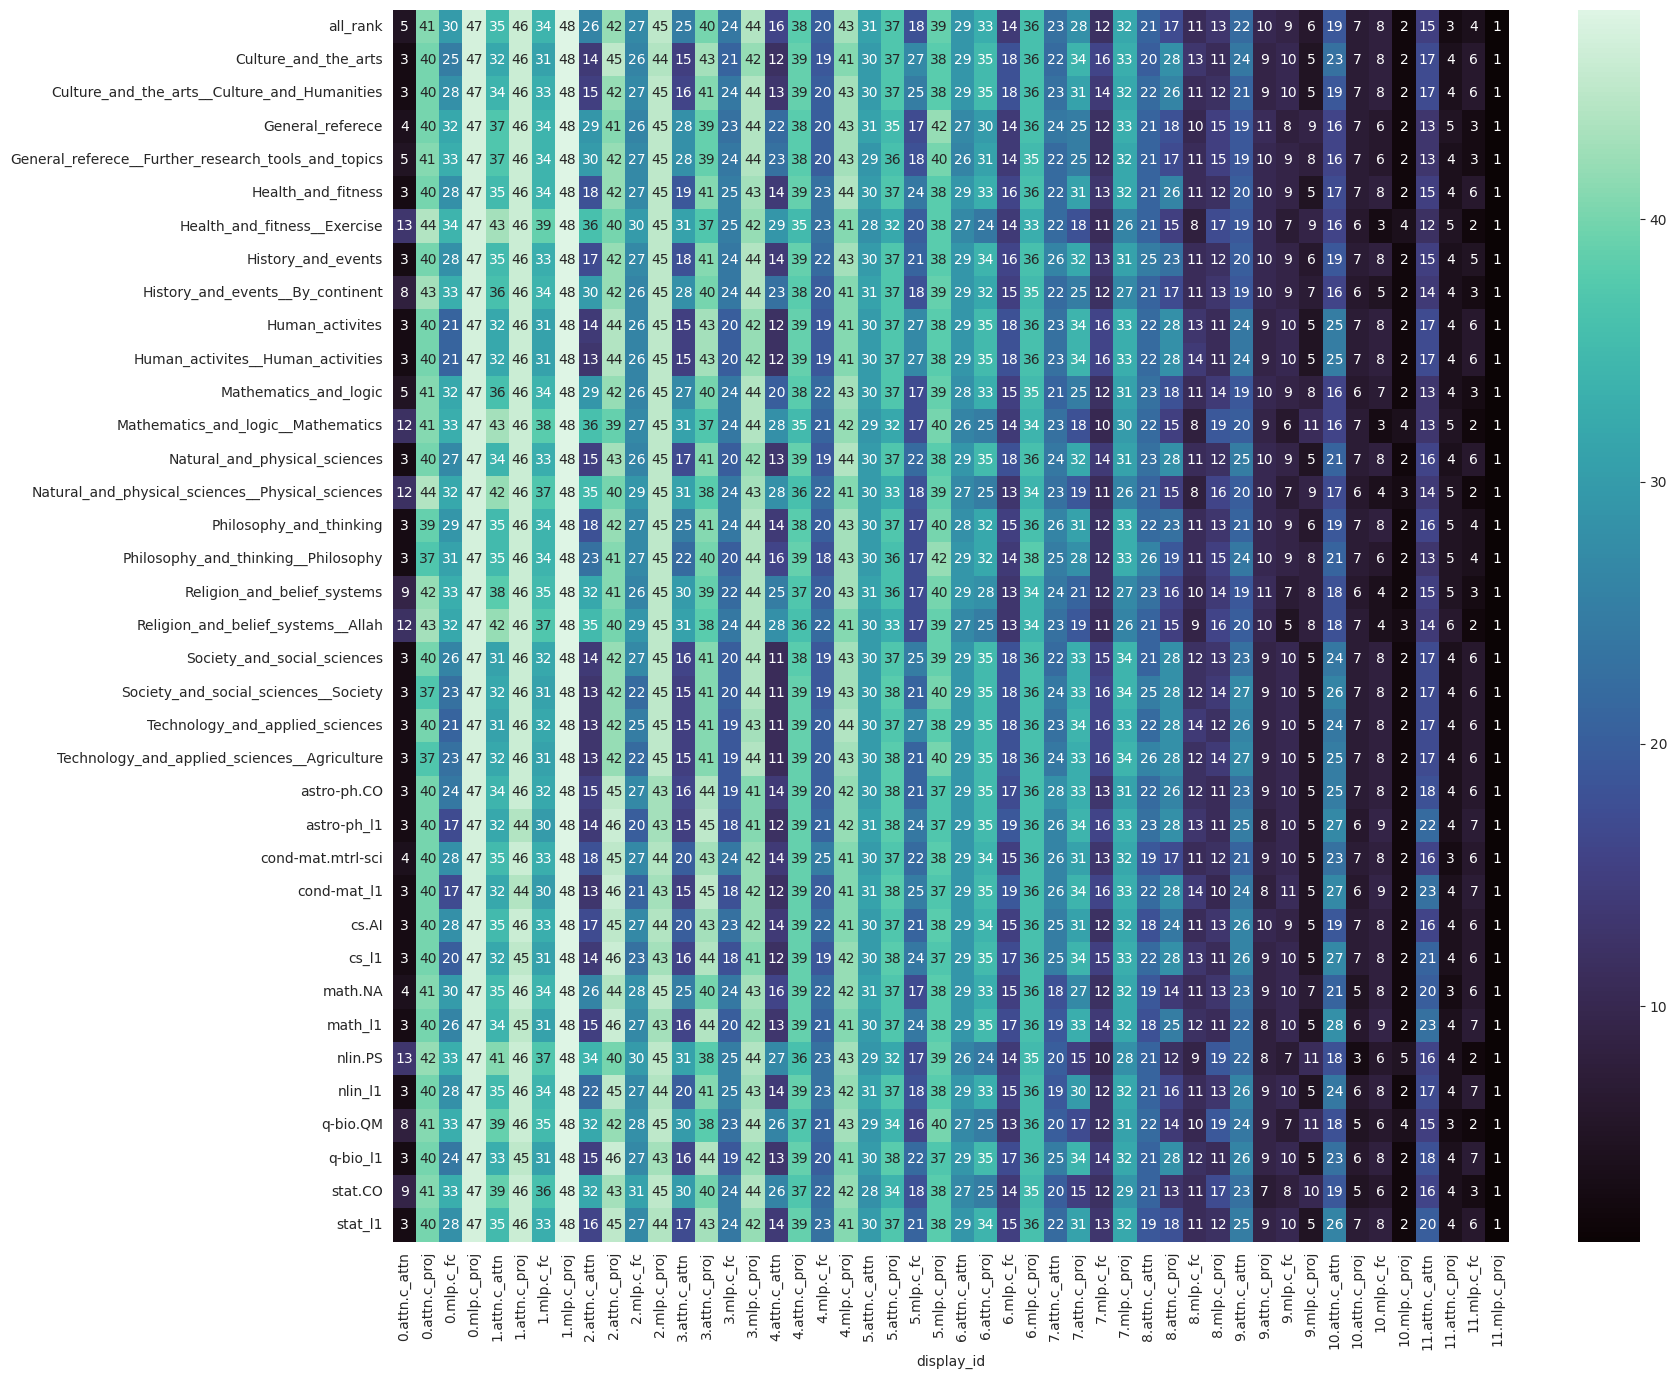

In [67]:
plt.rcParams["figure.figsize"] = (18,16)
sns.heatmap(
    df_corr,
    annot=True,
    cmap="mako"
)


If `all_rank` and `in_rank_mean_rank` are too different, it is hard to see that `all_rank` can represent individual rankings.

In [73]:
df_ranking["in_rank_mean_rank"] = df_ranking["in_rank_mean"].rank().fillna(-1).astype(int)
df_ranking.dropna().sort_values("all_rank")[["trace_id", "threshold", "all_rank", "in_rank_mean_rank", "in_rank_mean", "in_rank_std"]]

,trace_id,threshold,all_rank,in_rank_mean_rank,in_rank_mean,in_rank_std
27,transformer.h.11.mlp.c_proj,25,1,1,1.000000,0.000000
28,transformer.h.10.mlp.c_proj,25,2,2,2.305556,0.749074
29,transformer.h.11.attn.c_proj,25,3,3,4.166667,0.609449
30,transformer.h.11.mlp.c_fc,25,4,4,4.833333,1.812654
31,transformer.h.0.attn.c_attn,25,5,5,5.111111,3.445724
32,transformer.h.9.mlp.c_proj,25,6,7,6.555556,2.062515
33,transformer.h.10.attn.c_proj,25,7,6,6.444444,0.876501
34,transformer.h.10.mlp.c_fc,25,8,8,7.027778,1.698505
35,transformer.h.9.mlp.c_fc,25,9,9,9.000000,1.393864
36,transformer.h.9.attn.c_proj,25,10,10,9.277778,0.848902


### Correlations between all_rank and in_rank

In [74]:
# df_diff_weights.loc[df_diff_weights.is_investigated, ["trace_id", "in_rank"]]\
#     .merge(df_all[["trace_id", "all_rank"]], on="trace_id")[["in_rank", "all_rank"]].corr()

In [75]:
# df_diff_weights.loc[df_diff_weights.is_investigated, ["trace_id", "in_rank"]]\
#     .merge(df_all[["trace_id", "all_rank"]], on="trace_id")[["in_rank", "all_rank"]].corr("kendall")

In [76]:
df_temp = df_diff_weights.loc[df_diff_weights.is_investigated][["dataset", "trace_id", "in_rank"]]\
    .merge(df_all_ranking[["trace_id", "all_rank"]], on="trace_id")#[["v2_in_rank", "v2_rank"]]

print("the mean and std of pearson correlation between the rankings: \t", 
      df_temp.groupby(["dataset"])[["all_rank", "in_rank"]].corr().mean()["all_rank"].round(3), "\t",
      df_temp.groupby(["dataset"])[["all_rank", "in_rank"]].corr().std()["all_rank"].round(3))

print("the mean and std of kendall correlation between the rankings: \t", 
      df_temp.groupby(["dataset"])[["all_rank", "in_rank"]].corr("kendall").mean()["all_rank"].round(3), "\t",
      df_temp.groupby(["dataset"])[["all_rank", "in_rank"]].corr("kendall").std()["all_rank"].round(3))


the mean and std of pearson correlation between the rankings: 	 0.986 	 0.018
the mean and std of kendall correlation between the rankings: 	 0.944 	 0.063


the all_ranking can represent individual_rankings well.

# Clustering

In [77]:
from sklearn.cluster import KMeans

/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/l

Text(0.5, 1.0, 'Elbow curve')

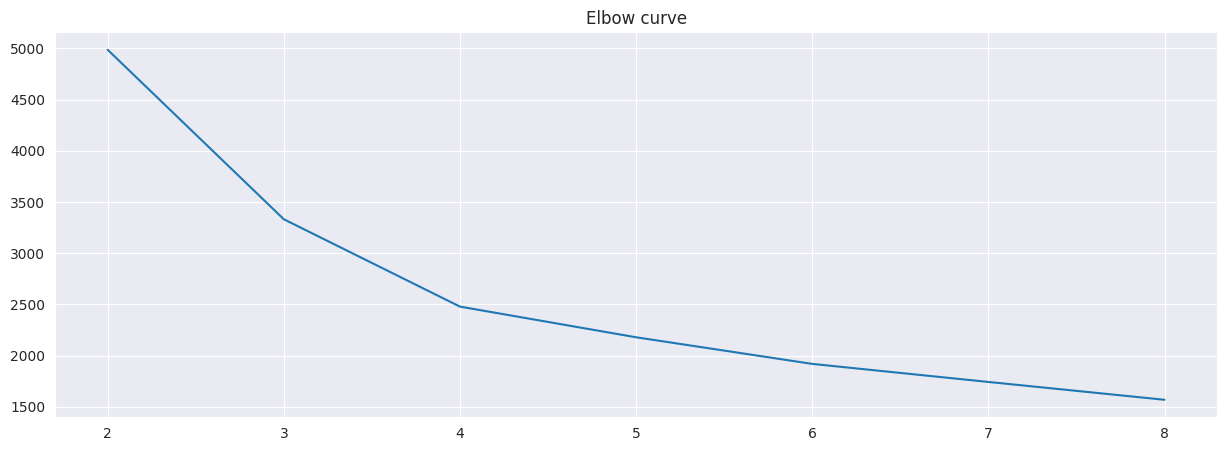

In [78]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = df_corr.values
distorsions = []
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 9), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [79]:
df_cluster = df_corr[:]
df_cluster = df_cluster.join(df_dataset.set_index("dataset"))[["source", "category"]]
df_cluster["y"] = KMeans(n_clusters=3).fit_predict(df_corr.values)
df_cluster = df_cluster.fillna("all")
df_cluster = df_cluster.reset_index(names="ds_nm")

/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [80]:
df_cluster.groupby(["y", "source"])[["source"]].count().unstack(-1)\
    .join(df_cluster.groupby(["y", "category"])[["category"]].count().unstack(-1)).fillna(0).astype(int)

source          category       
   S2ORC WIKI all       L1 L2 all
y                                
0      6    8   0       10  4   0
1      3    9   0        3  9   0
2      5    5   1        5  5   1

In [81]:
df_cluster.sort_values(["y", "ds_nm"])

,ds_nm,source,category,y
1,Culture_and_the_arts,WIKI,L1,0
9,Human_activites,WIKI,L1,0
10,Human_activites__Human_activities,WIKI,L2,0
13,Natural_and_physical_sciences,WIKI,L1,0
19,Society_and_social_sciences,WIKI,L1,0
20,Society_and_social_sciences__Society,WIKI,L2,0
21,Technology_and_applied_sciences,WIKI,L1,0
22,Technology_and_applied_sciences__Agriculture,WIKI,L2,0
23,astro-ph.CO,S2ORC,L2,0
24,astro-ph_l1,S2ORC,L1,0


# Results: Components by threshold

In [82]:
n_total_params = sum(p.numel() for p in base_model.parameters())

In [49]:
df_submodules_agg = df_all_ranking.groupby(["threshold"]).agg({
    "trace_id": [list],
    "total": ["count", "sum"],
})

df_submodules_agg.columns = ["trace_ids", "mod_cnt", "params"]
df_submodules_agg["prop"] = df_submodules_agg["params"] / n_total_params
df_submodules_agg["accum_params"] = df_submodules_agg["params"].cumsum()
df_submodules_agg["accum_prop_params"] = df_submodules_agg["accum_params"] / n_total_params
df_submodules_agg["trace_ids"] = df_submodules_agg["trace_ids"].apply(lambda l: ", ".join(l))
df_submodules_agg

,trace_ids,mod_cnt,params,prop,accum_params,accum_prop_params
threshold,,,,,,
-1,"transformer.wpe, transformer.wte, transformer....",27,39422208,0.316797,39422208,0.316797
25,"transformer.h.0.attn.c_attn, transformer.h.7.m...",12,22435584,0.180293,61857792,0.497090
50,"transformer.h.4.mlp.c_fc, transformer.h.5.mlp....",11,19487232,0.156600,81345024,0.653690
75,"transformer.h.0.mlp.c_fc, transformer.h.2.attn...",12,21847296,0.175565,103192320,0.829255
100,"transformer.h.0.attn.c_proj, transformer.h.0.m...",13,21247488,0.170745,124439808,1.000000


## Group 1: Non-investigated components

In [50]:
df_all_ranking.loc[df_all_ranking.threshold == -1]

,is_investigated,layer,display_id,trace_id,module,submodule,total,diff,scaled_diff,all_rank,accum_params,threshold
0,False,-1,-1.wpe,transformer.wpe,wpe,wpe,786432,0.010699,0.003764,-1,-1,-1
1,False,-1,-1.wte,transformer.wte,wte,wte,38597376,0.020407,0.005090,-1,-1,-1
2,False,0,0.ln_1,transformer.h.0.ln_1,ln_1,ln_1,1536,0.037720,0.010156,-1,-1,-1
3,False,0,0.ln_2,transformer.h.0.ln_2,ln_2,ln_2,1536,0.024450,0.007140,-1,-1,-1
4,False,1,1.ln_1,transformer.h.1.ln_1,ln_1,ln_1,1536,0.014657,0.003462,-1,-1,-1
5,False,1,1.ln_2,transformer.h.1.ln_2,ln_2,ln_2,1536,0.009845,0.002418,-1,-1,-1
6,False,2,2.ln_1,transformer.h.2.ln_1,ln_1,ln_1,1536,0.018558,0.004342,-1,-1,-1
7,False,2,2.ln_2,transformer.h.2.ln_2,ln_2,ln_2,1536,0.012230,0.002951,-1,-1,-1
8,False,3,3.ln_1,transformer.h.3.ln_1,ln_1,ln_1,1536,0.020723,0.004357,-1,-1,-1
9,False,3,3.ln_2,transformer.h.3.ln_2,ln_2,ln_2,1536,0.014724,0.003389,-1,-1,-1


## Group 2: top 0~25%

In [55]:
df_all_ranking.loc[df_all_ranking.threshold == 25].sort_values("all_rank")

,is_investigated,layer,display_id,trace_id,module,submodule,total,diff,scaled_diff,all_rank,accum_params,threshold
74,True,11,11.mlp.c_proj,transformer.h.11.mlp.c_proj,mlp,c_proj,2360064,0.026788,0.006778,1,2360064,25
73,True,11,11.mlp.c_fc,transformer.h.11.mlp.c_fc,mlp,c_fc,2362368,0.022606,0.006468,2,4722432,25
70,True,10,10.mlp.c_proj,transformer.h.10.mlp.c_proj,mlp,c_proj,2360064,0.024519,0.006267,3,7082496,25
72,True,11,11.attn.c_proj,transformer.h.11.attn.c_proj,attn,c_proj,590592,0.022995,0.006241,4,7673088,25
68,True,10,10.attn.c_proj,transformer.h.10.attn.c_proj,attn,c_proj,590592,0.022138,0.006181,5,8263680,25
69,True,10,10.mlp.c_fc,transformer.h.10.mlp.c_fc,mlp,c_fc,2362368,0.021527,0.006150,6,10626048,25
65,True,9,9.mlp.c_fc,transformer.h.9.mlp.c_fc,mlp,c_fc,2362368,0.021007,0.005968,7,12988416,25
61,True,8,8.mlp.c_fc,transformer.h.8.mlp.c_fc,mlp,c_fc,2362368,0.020455,0.005785,8,15350784,25
64,True,9,9.attn.c_proj,transformer.h.9.attn.c_proj,attn,c_proj,590592,0.020890,0.005773,9,15941376,25
66,True,9,9.mlp.c_proj,transformer.h.9.mlp.c_proj,mlp,c_proj,2360064,0.021950,0.005704,10,18301440,25


## Group 3: top 25~50%

In [56]:
df_all_ranking.loc[df_all_ranking.threshold == 50].sort_values("all_rank")

,is_investigated,layer,display_id,trace_id,module,submodule,total,diff,scaled_diff,all_rank,accum_params,threshold
53,True,6,6.mlp.c_fc,transformer.h.6.mlp.c_fc,mlp,c_fc,2362368,0.019429,0.005436,13,24797952,50
71,True,11,11.attn.c_attn,transformer.h.11.attn.c_attn,attn,c_attn,1771776,0.019315,0.005398,14,26569728,50
60,True,8,8.attn.c_proj,transformer.h.8.attn.c_proj,attn,c_proj,590592,0.019145,0.005369,15,27160320,50
67,True,10,10.attn.c_attn,transformer.h.10.attn.c_attn,attn,c_attn,1771776,0.019027,0.005282,16,28932096,50
49,True,5,5.mlp.c_fc,transformer.h.5.mlp.c_fc,mlp,c_fc,2362368,0.019027,0.005279,17,31294464,50
56,True,7,7.attn.c_proj,transformer.h.7.attn.c_proj,attn,c_proj,590592,0.018286,0.005236,18,31885056,50
62,True,8,8.mlp.c_proj,transformer.h.8.mlp.c_proj,mlp,c_proj,2360064,0.019609,0.005229,19,34245120,50
45,True,4,4.mlp.c_fc,transformer.h.4.mlp.c_fc,mlp,c_fc,2362368,0.018864,0.005151,20,36607488,50
55,True,7,7.attn.c_attn,transformer.h.7.attn.c_attn,attn,c_attn,1771776,0.018865,0.005150,21,38379264,50
59,True,8,8.attn.c_attn,transformer.h.8.attn.c_attn,attn,c_attn,1771776,0.018884,0.005144,22,40151040,50


## Group 4: top 50~75%

In [57]:
df_all_ranking.loc[df_all_ranking.threshold == 75].sort_values("all_rank")

,is_investigated,layer,display_id,trace_id,module,submodule,total,diff,scaled_diff,all_rank,accum_params,threshold
41,True,3,3.mlp.c_fc,transformer.h.3.mlp.c_fc,mlp,c_fc,2362368,0.018773,0.005087,24,44285184,75
52,True,6,6.attn.c_proj,transformer.h.6.attn.c_proj,attn,c_proj,590592,0.017663,0.005002,25,44875776,75
51,True,6,6.attn.c_attn,transformer.h.6.attn.c_attn,attn,c_attn,1771776,0.018176,0.004923,26,46647552,75
43,True,4,4.attn.c_attn,transformer.h.4.attn.c_attn,attn,c_attn,1771776,0.019025,0.004922,27,48419328,75
37,True,2,2.mlp.c_fc,transformer.h.2.mlp.c_fc,mlp,c_fc,2362368,0.018346,0.004896,28,50781696,75
47,True,5,5.attn.c_attn,transformer.h.5.attn.c_attn,attn,c_attn,1771776,0.017968,0.004872,29,52553472,75
58,True,7,7.mlp.c_proj,transformer.h.7.mlp.c_proj,mlp,c_proj,2360064,0.017760,0.004860,30,54913536,75
39,True,3,3.attn.c_attn,transformer.h.3.attn.c_attn,attn,c_attn,1771776,0.018508,0.004764,31,56685312,75
29,True,0,0.mlp.c_fc,transformer.h.0.mlp.c_fc,mlp,c_fc,2362368,0.018003,0.004644,32,59047680,75
48,True,5,5.attn.c_proj,transformer.h.5.attn.c_proj,attn,c_proj,590592,0.015536,0.004579,33,59638272,75


## Group 5: top 75~100%

In [58]:
df_all_ranking.loc[df_all_ranking.threshold == 100].sort_values("all_rank")

,is_investigated,layer,display_id,trace_id,module,submodule,total,diff,scaled_diff,all_rank,accum_params,threshold
33,True,1,1.mlp.c_fc,transformer.h.1.mlp.c_fc,mlp,c_fc,2362368,0.017095,0.004465,36,66132480,100
44,True,4,4.attn.c_proj,transformer.h.4.attn.c_proj,attn,c_proj,590592,0.015058,0.004424,37,66723072,100
40,True,3,3.attn.c_proj,transformer.h.3.attn.c_proj,attn,c_proj,590592,0.014387,0.004317,38,67313664,100
50,True,5,5.mlp.c_proj,transformer.h.5.mlp.c_proj,mlp,c_proj,2360064,0.014953,0.004207,39,69673728,100
28,True,0,0.attn.c_proj,transformer.h.0.attn.c_proj,attn,c_proj,590592,0.014293,0.004108,40,70264320,100
36,True,2,2.attn.c_proj,transformer.h.2.attn.c_proj,attn,c_proj,590592,0.013854,0.004073,41,70854912,100
31,True,1,1.attn.c_attn,transformer.h.1.attn.c_attn,attn,c_attn,1771776,0.016457,0.004046,42,72626688,100
46,True,4,4.mlp.c_proj,transformer.h.4.mlp.c_proj,mlp,c_proj,2360064,0.013976,0.003964,43,74986752,100
42,True,3,3.mlp.c_proj,transformer.h.3.mlp.c_proj,mlp,c_proj,2360064,0.013873,0.003898,44,77346816,100
38,True,2,2.mlp.c_proj,transformer.h.2.mlp.c_proj,mlp,c_proj,2360064,0.013566,0.003788,45,79706880,100


In [ ]:
df_submodule

In [83]:
df_temp = pd.read_pickle("./data/df_localisation_result_230711.pkl")

In [85]:
df_temp.head()

,code,is_in_layer,is_investigated,layer,module,params,submodule,trace_id,w_or_b,display_id,total,threshold_w
0,transformer.wte.weight,False,False,-1,wte,38597376,wte,transformer.wte,weight,-1.wte,38597376,-1
1,transformer.wpe.weight,False,False,-1,wpe,786432,wpe,transformer.wpe,weight,-1.wpe,786432,-1
2,transformer.h.0.ln_1.weight,True,False,0,ln_1,768,ln_1,transformer.h.0.ln_1,weight,0.ln_1,1536,-1
3,transformer.h.0.ln_1.bias,True,False,0,ln_1,768,ln_1,transformer.h.0.ln_1,bias,0.ln_1,1536,-1
4,transformer.h.0.attn.c_attn.weight,True,True,0,attn,1769472,c_attn,transformer.h.0.attn.c_attn,weight,0.attn.c_attn,1771776,25


In [86]:
df_temp.columns

Index(['code', 'is_in_layer', 'is_investigated', 'layer', 'module', 'params',
       'submodule', 'trace_id', 'w_or_b', 'display_id', 'total',
       'threshold_w'],
      dtype='object')

In [87]:
df_submodule.columns

Index(['code', 'is_in_layer', 'is_investigated', 'layer', 'module', 'params',
       'submodule', 'trace_id', 'w_or_b', 'display_id', 'total'],
      dtype='object')

In [88]:
df_all_ranking.columns

Index(['is_investigated', 'layer', 'display_id', 'trace_id', 'module',
       'submodule', 'total', 'diff', 'scaled_diff', 'all_rank', 'accum_params',
       'threshold'],
      dtype='object')

In [93]:
df_result = df_submodule.merge(df_all_ranking[["trace_id", "threshold"]], on="trace_id")

In [94]:
df_result

,code,is_in_layer,is_investigated,layer,module,params,submodule,trace_id,w_or_b,display_id,total,threshold
0,transformer.wte.weight,False,False,-1,wte,38597376,wte,transformer.wte,weight,-1.wte,38597376,-1
1,transformer.wpe.weight,False,False,-1,wpe,786432,wpe,transformer.wpe,weight,-1.wpe,786432,-1
2,transformer.h.0.ln_1.weight,True,True,0,ln_1,768,ln_1,transformer.h.0.ln_1,weight,0.ln_1,1536,-1
3,transformer.h.0.ln_1.bias,True,True,0,ln_1,768,ln_1,transformer.h.0.ln_1,bias,0.ln_1,1536,-1
4,transformer.h.0.attn.c_attn.weight,True,True,0,attn,1769472,c_attn,transformer.h.0.attn.c_attn,weight,0.attn.c_attn,1771776,25
...,...,...,...,...,...,...,...,...,...,...,...,...
143,transformer.h.11.mlp.c_fc.bias,True,True,11,mlp,3072,c_fc,transformer.h.11.mlp.c_fc,bias,11.mlp.c_fc,2362368,25
144,transformer.h.11.mlp.c_proj.weight,True,True,11,mlp,2359296,c_proj,transformer.h.11.mlp.c_proj,weight,11.mlp.c_proj,2360064,25
145,transformer.h.11.mlp.c_proj.bias,True,True,11,mlp,768,c_proj,transformer.h.11.mlp.c_proj,bias,11.mlp.c_proj,2360064,25
146,transformer.ln_f.weight,False,True,99,ln_f,768,ln_f,transformer.ln_f,weight,99.ln_f,1536,-1


In [ ]:
df_result.to_pickle("./data/df_localisation_weight_230806.pkl")

<!-- ## Params for Editing or Compression -->

In [252]:
df_n_module_params_agg_v2 = df_n_module_params_agg.reset_index().drop("is_localised", axis=1)
df_n_module_params_agg_v2.columns = ["module", "bias", "weight"]
df_n_module_params_agg_v2["total"] = df_n_module_params_agg_v2["bias"] + df_n_module_params_agg_v2["weight"] 

NameError: name 'df_n_module_params_agg' is not defined

In [21]:
df_modules = df_avg_diff_weights\
    .groupby(["is_in_layer", "is_localised", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_n_module_params_agg_v2, on=["module"], how='left')

df_modules.loc[df_modules.is_localised, "rank"]\
    = df_modules.loc[df_modules.is_localised]["scaled_diff"].rank(ascending=False)
df_modules["rank"] = df_modules["rank"].fillna(-1).astype(int)

In [22]:
df_modules.total.sum()

124439808

In [23]:
n_total_params = sum(p.numel() for p in base_model.parameters())
n_total_params

124439808

In [24]:
n_localised_mods = len(df_modules.loc[df_modules["is_localised"]])
df_modules['threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_modules.loc[df_modules["rank"] < threshold*n_localised_mods, 'threshold'] = int(threshold * 100)

df_modules_agg = df_modules.groupby(["threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))


In [29]:
df_modules_agg.to_csv("df_modules_agg.tsv", sep='\t')

<!-- ## IN vs. ALL Rank Comparision -->

In [137]:
df_avg_diff_weights.loc[df_avg_diff_weights.is_localised, "in_rank"] \
    = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["dataset"])["diff"].rank(ascending=False)
# df_avg_diff_weights.loc[df_avg_diff_weights.is_localised, "in_scaled_rank"] \
#     = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["dataset"])["scaled_diff"].rank(ascending=False)

df_avg_diff_weights["in_rank"] = df_avg_diff_weights["in_rank"].fillna(-1).astype(int)
# df_avg_diff_weights["in_scaled_rank"] = df_avg_diff_weights["in_scaled_rank"].fillna(-1).astype(int)


df_in_rank = df_avg_diff_weights.loc[df_avg_diff_weights.is_localised].groupby(["layer", "component_id"])["in_rank"].describe()[["mean", "std"]]
df_in_rank = df_in_rank.rename({"mean":"in_rank_mean", "std":"in_rank_std"}, axis=1)

df_modules.loc[df_modules.is_localised, ["layer", "component_id", "threshold", "rank"]].sort_values('rank')\
    .rename({"rank": "all_rank"}, axis=1)\
    .merge(df_in_rank.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

<!-- # Visualisation -->

<!-- ### boxplot for the scaled and mean weight- and bias-differences by layers -->


<Axes: xlabel='layer', ylabel='scaled_diff'>

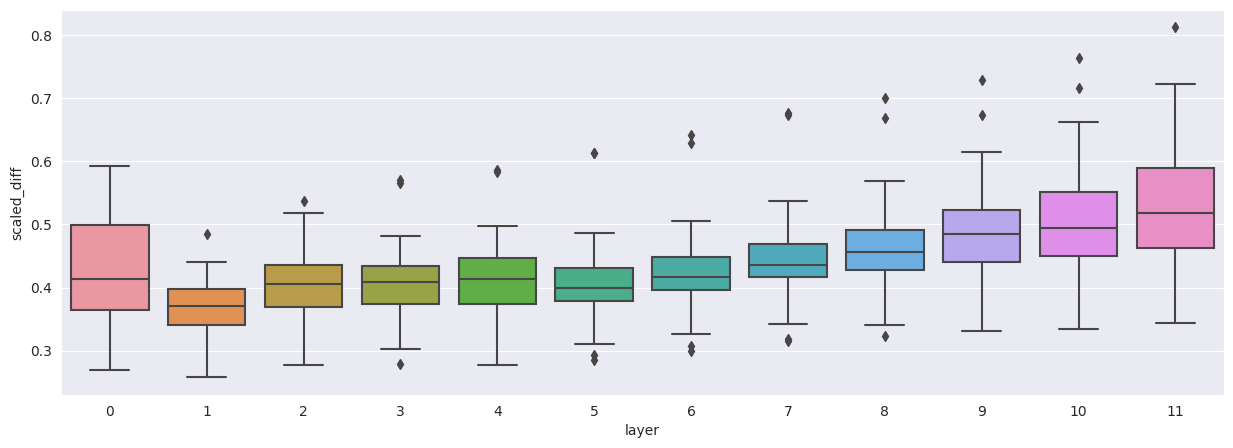

In [91]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

<Axes: xlabel='layer', ylabel='scaled_diff'>

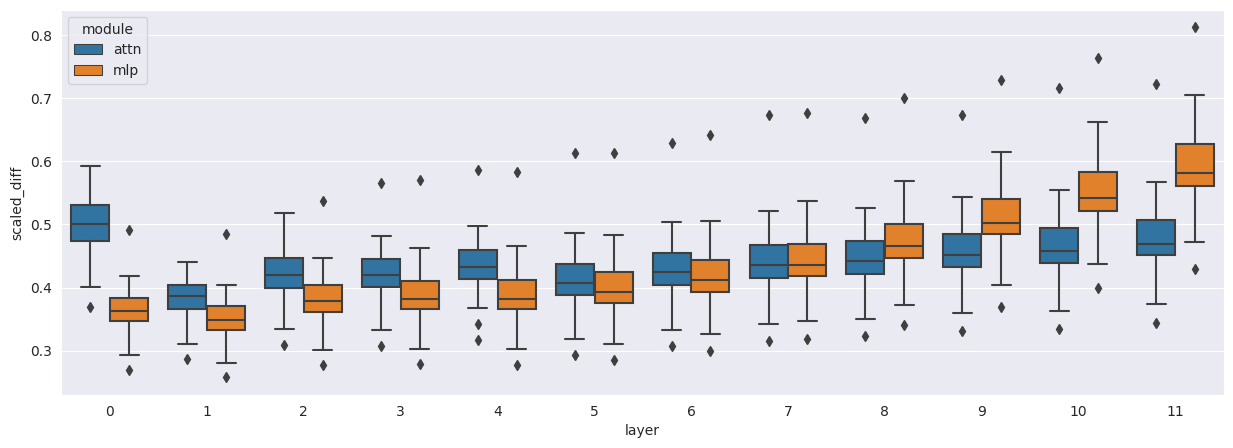

In [46]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff', hue='module'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)